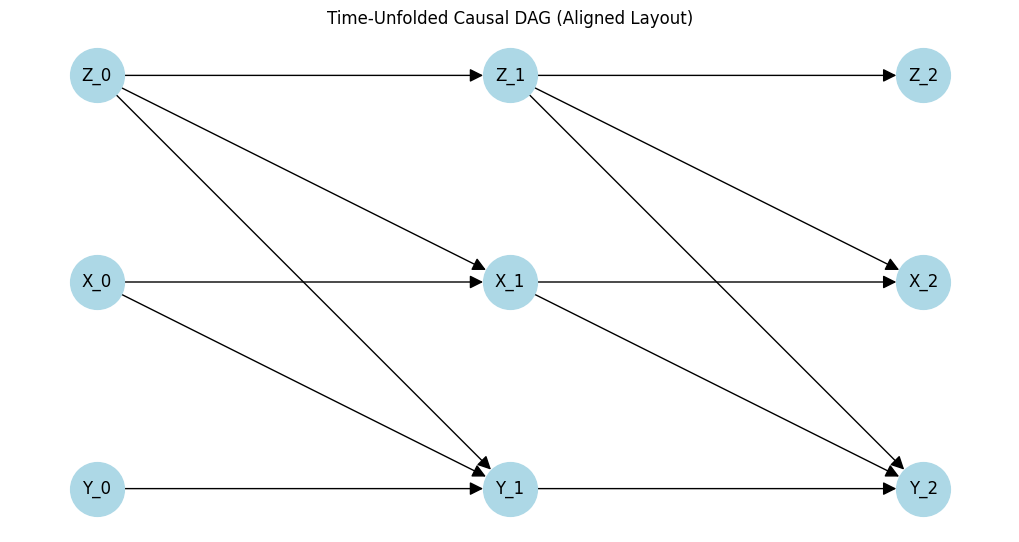

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

def build_time_unfolded_dag(dag_edges, nodes, timesteps=3):
    G = nx.DiGraph()
    
    # Add nodes
    for t in range(timesteps):
        for i, node in enumerate(nodes):
            G.add_node(f"{node}_{t}", pos=(t, -i))  # (time, variable index)
    
    # Autoregressive edges
    for t in range(1, timesteps):
        for node in nodes:
            G.add_edge(f"{node}_{t-1}", f"{node}_{t}")
    
    # Causal DAG edges across time
    for t in range(1, timesteps):
        for parent, child in dag_edges:
            G.add_edge(f"{parent}_{t-1}", f"{child}_{t}")
    
    return G

# Example DAG: Z → X → Y, Z → Y
nodes = ["Z", "X", "Y"]
dag_edges = [("Z","X"), ("X","Y"), ("Z","Y")]

# Build unfolded graph
G_time = build_time_unfolded_dag(dag_edges, nodes, timesteps=3)

# Extract positions from attributes
pos = nx.get_node_attributes(G_time, "pos")

# Plot
plt.figure(figsize=(10,5))
nx.draw(G_time, pos, with_labels=True, node_size=1500, node_color="lightblue", arrowsize=20)
plt.title("Time-Unfolded Causal DAG (Aligned Layout)")
plt.show()


In [18]:
import numpy as np
import pandas as pd

def generate_data(T=100, noise_std=0.1, seed=0):
    np.random.seed(seed)
    X, Y, Z = np.zeros(T), np.zeros(T), np.zeros(T)
    for t in range(1, T):
        # autoregressive parts
        X[t] = 0.8 * X[t-1] + np.random.normal(0, noise_std)
        Y[t] = 0.5 * Y[t-1] + 0.7 * X[t] + np.random.normal(0, noise_std)
        Z[t] = 0.6 * Z[t-1] + 0.5 * Y[t] + np.random.normal(0, noise_std)
    return pd.DataFrame({"X": X, "Y": Y, "Z": Z})

In [19]:
data = generate_data(T=200)

In [24]:
def build_time_unfolded_dag(dag_edges, nodes, autoreg_weights=None, timesteps=3):
    """
    dag_edges: list of (parent, child, weight)
    autoreg_weights: dict {node: weight} for autoregressive edges
    """
    G = nx.DiGraph()
    
    # Add nodes
    for t in range(timesteps):
        for i, node in enumerate(nodes):
            G.add_node(f"{node}_{t}", pos=(t, -i))
    
    # Autoregressive edges
    if autoreg_weights is None:
        autoreg_weights = {node: 1.0 for node in nodes}
        
    for t in range(1, timesteps):
        for node in nodes:
            G.add_edge(f"{node}_{t-1}", f"{node}_{t}", weight=autoreg_weights[node])
    
    # Causal DAG edges across time
    for t in range(1, timesteps):
        for parent, child, w in dag_edges:
            G.add_edge(f"{parent}_{t-1}", f"{child}_{t}", weight=w)
    
    return G


In [31]:
G = build_time_unfolded_dag(dag_edges, nodes, autoreg_weights, timesteps=3)


In [32]:
def generate_data_from_dag(G, nodes, T=100, noise_std=0.1, seed=0):
    np.random.seed(seed)
    data = {node: np.zeros(T) for node in nodes}
    
    for t in range(1, T):
        for node in nodes:
            curr = f"{node}_{t}"
            parents = list(G.predecessors(curr))
            
            val = 0.0
            for p in parents:
                p_node, p_t = p.split("_")
                w = G[p][curr]["weight"]  # use stored edge weight
                val += w * data[p_node][int(p_t)]
            
            data[node][t] = val + np.random.normal(0, noise_std)
    
    return pd.DataFrame(data)


In [48]:
dag_edges = [
    ("X", "Y", 0.7),  # X_t → Y_t
    ("Y", "Z", 0.5)   # Y_t → Z_t
]
autoreg_weights = {"X": 0.8, "Y": 0.5, "Z": 0.6}

nodes = ["X", "Y", "Z"]
G = build_time_unfolded_dag(dag_edges, nodes, autoreg_weights, timesteps=2)

df = generate_data_from_dag(G, nodes, T=2)
print(df.head())


          X         Y         Z
0  0.000000  0.000000  0.000000
1  0.176405  0.040016  0.097874


In [50]:
def plot_time_unfolded_dag(G, figsize=(10,5)):
    pos = nx.get_node_attributes(G, "pos")   # use stored (time, -var_index)
    edge_labels = nx.get_edge_attributes(G, "weight")  # show weights
    
    plt.figure(figsize=figsize)
    nx.draw(
        G, pos, 
        with_labels=True, 
        node_size=800, 
        node_color="lightblue", 
        arrowsize=15, 
        font_size=8
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    plt.axis("off")
    plt.show()

In [51]:
G.nodes

NodeView(('X_0', 'Y_0', 'Z_0', 'X_1', 'Y_1', 'Z_1'))

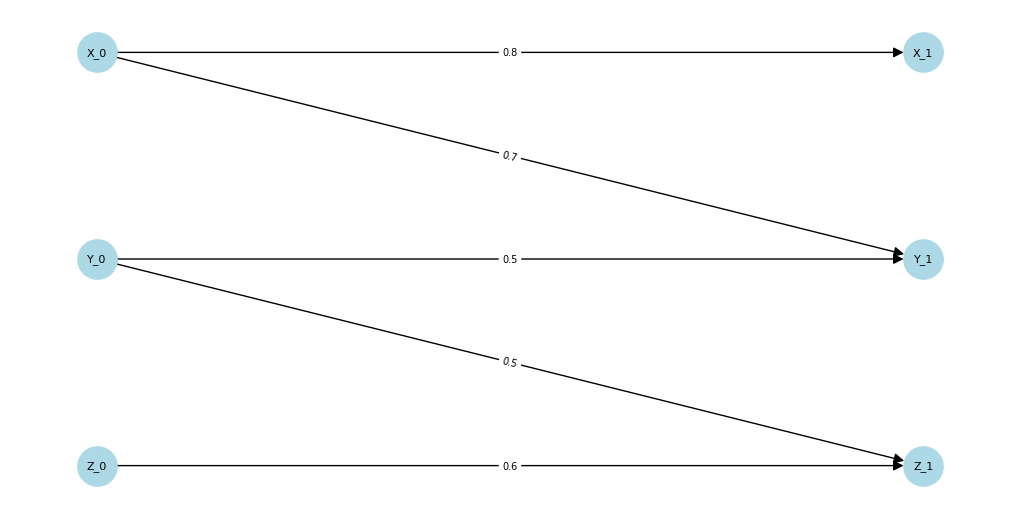

In [52]:
plot_time_unfolded_dag(G)